In [8]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

In [9]:
from typing import List

import diffrax
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax

In [10]:
def generate_lorenz(
    t0=0.0,  # set start time
    t1=2.0,  # set end time
    batch_size=1024,  # number of trajectories
    a=(10.0, 28.0, 8.0 / 3),  # coefficient for drift function
    b=(0.15, 0.15, 0.15),  # coefficient for difussion funcion
    normalize=True,  # whether to normialize data
    noise_std=0.01,  # add noise to training data
    *,
    key,
):
    ts = jnp.linspace(t0, t1, num=100)

    # define drift function
    def drift(t, y, args):
        a1, a2, a3 = a
        x1, x2, x3 = y

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return jnp.concatenate([f1[None], f2[None], f3[None]])

    # define diffusion function
    def diffusion(t, y, args):
        b1, b2, b3 = b
        x1, x2, x3 = y

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return jnp.concatenate([g1[None], g2[None], g3[None]])

    # sample via SDE solver
    def integrate(y0, path_key):
        bm = diffrax.UnsafeBrownianPath(shape=(3,), key=path_key)
        lorenz_sde = diffrax.MultiTerm(
            diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, bm)
        )
        saveat = diffrax.SaveAt(ts=ts)
        solver = diffrax.Euler()
        sol = diffrax.diffeqsolve(
            lorenz_sde,
            solver,
            t0=t0,
            t1=t1,
            y0=y0,
            saveat=saveat,
            dt0=1e-3,
            adjoint=diffrax.DirectAdjoint(),
        )
        return sol.ys

    y0_key, bm_key, noise_key = jrandom.split(key, 3)
    y0 = jrandom.normal(key=y0_key, shape=(batch_size, 3))
    path_key = jrandom.split(bm_key, batch_size)
    ys = jax.vmap(integrate)(y0, path_key)

    if normalize:
        mean_y = jnp.mean(ys, axis=(0, 1), keepdims=True)
        std_y = jnp.std(ys, axis=(0, 1), keepdims=True)
        ys = (ys - mean_y) / std_y + jrandom.normal(
            key=noise_key, shape=ys.shape
        ) * noise_std
    else:
        ys = ys + jrandom.normal(key=noise_key, shape=ys.shape) * noise_std

    return ts, ys

In [11]:
class Encoder(eqx.Module):
    gru: eqx.nn.GRUCell
    linear: eqx.nn.Linear

    def __init__(self, input_size, hidden_size, output_size, *, key) -> None:
        gru_key, linear_key = jrandom.split(key)
        self.gru = eqx.nn.GRUCell(
            input_size=input_size, hidden_size=hidden_size, key=gru_key
        )
        self.linear = eqx.nn.Linear(
            in_features=hidden_size, out_features=output_size, key=linear_key
        )

    def __call__(self, x):
        def scan_fn(state, inputs):
            new_state = self.gru(inputs, state)
            return new_state, new_state
            
        init_state = jnp.zeros(self.gru.hidden_size)
        _, out = jax.lax.scan(scan_fn, init_state, x)
        out = jax.vmap(self.linear)(out)
        return out

In [24]:
class DriftPosterior(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, latent_size, context_size, hidden_size, *, key) -> None:
        self.net = eqx.nn.MLP(
            in_size=latent_size + context_size,
            width_size=hidden_size,
            out_size=latent_size,
            depth=2,
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        context = args
        return self.net(y)


class DriftPrior(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, latent_size, hidden_size, *, key):
        self.net = eqx.nn.MLP(
            in_size=latent_size,
            width_size=hidden_size,
            out_size=latent_size,
            depth=2,
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.net(y)


class Diffusion(eqx.Module):
    nets: List[eqx.nn.MLP]

    def __init__(self, latent_size, hidden_size, *, key):
        keys = jrandom.split(key, latent_size)
        self.nets = [
            eqx.nn.MLP(
                in_size=1,
                width_size=hidden_size,
                out_size=1,
                depth=1,
                activation=jax.nn.softplus,
                final_activation=jax.nn.sigmoid,
                key=i_key,
            )
            for i_key in keys
        ]

    def __call__(self, t, y, args):
        y = jnp.split(y, indices_or_sections=len(self.nets))
        out = [net_i(y_i) for net_i, y_i in zip(self.nets, y)]
        return jnp.concatenate(out, axis=0)

In [25]:
def normal_logprob(y, loc, scale):
    return -0.5 * ((y - loc) / scale) ** 2 - jnp.log(scale) - 0.5 * jnp.log(2 * jnp.pi)


def normal_kl_divergence(loc1, scale1, loc2, scale2):
    var_ratio = (scale1 / scale2) ** 2
    t1 = ((loc2 - loc1) / scale2) ** 2
    return 0.5 * (var_ratio + t1 - 1 - jnp.log(var_ratio))

In [26]:
class LatentSDE(eqx.Module):
    encoder: eqx.Module
    posterior_drift: eqx.Module
    prior_drift: eqx.Module
    diffusion: eqx.Module
    qz0_net: eqx.nn.Linear
    projector: eqx.nn.Linear
    pz0_mean: jnp.ndarray
    pz0_logstd: jnp.ndarray
    t0: float
    t1: float
    latent_size: int

    def __init__(
        self, data_size, latent_size, context_size, hidden_size, t0, t1, *, key
    ) -> None:
        self.t0, self.t1 = t0, t1
        self.latent_size = latent_size
        keys = jrandom.split(key, num=6)
        self.encoder = Encoder(
            input_size=data_size,
            hidden_size=hidden_size,
            output_size=context_size,
            key=keys[0],
        )
        self.qz0_net = eqx.nn.Linear(
            context_size, latent_size + latent_size, key=keys[1]
        )

        self.posterior_drift = DriftPosterior(
            latent_size=latent_size,
            context_size=context_size,
            hidden_size=hidden_size,
            key=keys[2],
        )
        self.prior_drift = DriftPrior(
            latent_size=latent_size, hidden_size=hidden_size, key=keys[3]
        )
        self.diffusion = Diffusion(
            latent_size=latent_size, hidden_size=hidden_size, key=keys[4]
        )
        self.projector = eqx.nn.Linear(latent_size, data_size, key=keys[5])
        self.pz0_mean = jnp.zeros(shape=(1, latent_size))
        self.pz0_logstd = jnp.zeros(shape=(1, latent_size))

    def integrate(self, y0, solver, context, dt=1e-2, saveat=None, *, key):
        """Solving SDE over latent space"""
        bm = diffrax.VirtualBrownianTree(
            t0=self.t0,
            t1=self.t1,
            shape=(self.latent_size,),
            tol=1e-3,
            key=key,
        )

        control_term = diffrax.WeaklyDiagonalControlTerm(self.diffusion, bm)
        posterior_drift = self.posterior_drift#diffrax.ODETerm(self.posterior_drift)
        prior_drift = self.prior_drift#diffrax.ODETerm(self.prior_drift)

        # get augmented SDEs
        aug_sde, aug_y0 = diffrax.sde_kl_divergence(
            drift1=posterior_drift,
            drift2=prior_drift,
            diffusion=control_term,
            y0=y0,
        )

        sol = diffrax.diffeqsolve(
            aug_sde,
            solver,
            t0=self.t0,
            t1=self.t1,
            dt0=dt,
            y0=aug_y0,
            saveat=saveat,
            args=context,  # pass context to args
        )
        # print(sol.stats)
        return sol.ys #(sol.ys[0], sol.ys[1][:sol.stats["num_steps"]])

    def __call__(self, xs, ts, key):
        """
        This extracts contexts from data via a recurrent neural network (GRU).
        The contexts then are fed to SDE over latent space.
        The function returns the trajectories of models after
        re-projecting from latent space into data space.
        """
        solver = diffrax.Euler()
        saveat = diffrax.SaveAt(ts=ts)

        eps_key, bm_key = jrandom.split(key)
        ctx = self.encoder(jnp.flip(xs, axis=0))
        ctx = jnp.flip(ctx, axis=0)

        def context(t):
            # find the index which is closet to the current time
            t_index = jnp.searchsorted(ts, t, side="right")
            # return the corresponding context
            return ctx[t_index]

        qz0_mean, qz0_logstd = jnp.split(
            self.qz0_net(ctx[0]), indices_or_sections=2, axis=-1
        )

        eps = jrandom.normal(key=eps_key, shape=qz0_logstd.shape)
        z0 = qz0_mean + jnp.exp(qz0_logstd) * eps
        zs, logpq_path = self.integrate(
            z0, solver=solver, context=context, saveat=saveat, key=bm_key
        )

        logpq0 = normal_kl_divergence(
            loc1=qz0_mean,
            scale1=jnp.exp(qz0_logstd),
            loc2=self.pz0_mean,
            scale2=jnp.exp(self.pz0_logstd),
        )
        logpq = logpq0.sum() + logpq_path#[-1]
        xs_pred = jax.vmap(self.projector)(zs)

        return xs_pred, logpq

    def sample(self, batch_size, ts, key, dt=1e-2):
        """Sample from prior drift"""

        eps_key, bm_key = jrandom.split(key)

        solver = diffrax.Euler()
        saveat = diffrax.SaveAt(ts=ts)

        def solve(z0, key):
            bm = diffrax.VirtualBrownianTree(
                t0=self.t0, t1=self.t1, shape=(self.latent_size,), tol=1e-3, key=key
            )
            control_term = diffrax.WeaklyDiagonalControlTerm(self.diffusion, bm)
            sde = diffrax.MultiTerm(diffrax.ODETerm(self.prior_drift), control_term)
            sol = diffrax.diffeqsolve(
                sde, solver, t0=self.t0, t1=self.t1, dt0=dt, y0=z0, saveat=saveat
            )
            return sol.ys

        eps = jrandom.normal(shape=(batch_size, *self.pz0_mean.shape[1:]), key=eps_key)
        z0s = self.pz0_mean + jnp.exp(self.pz0_logstd) * eps
        bm_keys = jrandom.split(bm_key, num=batch_size)
        batch_solve = jax.vmap(solve)
        zs = batch_solve(z0s, bm_keys)
        xs = jax.vmap(jax.vmap(self.projector))(zs)

        return xs

In [27]:
def visualize(model: LatentSDE, ts, xs, num_samples=5, *, key):
    fig = plt.figure(figsize=(18, 5))

    # plot data
    ax0 = fig.add_subplot(1, 3, 1, projection="3d")
    xs1, xs2, xs3 = jnp.split(xs, indices_or_sections=3, axis=-1)

    [ax0.plot(xs1[i, :, 0], xs2[i, :, 0], xs3[i, :, 0]) for i in range(num_samples)]
    ax0.scatter(
        xs1[:num_samples, 0, 0],
        xs2[:num_samples, 0, 0],
        xs3[:num_samples, 0, 0],
        marker="x",
    )
    ax0.set_xlabel(r"$x_1$")
    ax0.set_ylabel(r"$x_2$")
    ax0.set_zlabel(r"$x_3$")
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    zlim = ax0.get_zlim()
    ax0.set_title("Training data")

    # plot from prior
    ax1 = fig.add_subplot(1, 3, 2, projection="3d")
    xs_sample = model.sample(batch_size=num_samples, ts=ts, key=key)
    xs1, xs2, xs3 = jnp.split(xs_sample, indices_or_sections=3, axis=-1)

    [ax1.plot(xs1[i, :, 0], xs2[i, :, 0], xs3[i, :, 0]) for i in range(num_samples)]
    ax1.scatter(
        xs1[:num_samples, 0, 0],
        xs2[:num_samples, 0, 0],
        xs3[:num_samples, 0, 0],
        marker="x",
    )
    ax1.set_xlabel(r"$x_1$")
    ax1.set_ylabel(r"$x_2$")
    ax1.set_zlabel(r"$x_3$")
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_zlim(zlim)
    ax1.set_title("Samples from learned prior")

    # plot fit posterior
    ax2 = fig.add_subplot(1, 3, 3, projection="3d")
    ax2.scatter(xs[0, :, 0], xs[0, :, 1], xs[0, :, 2], marker="x")
    xs_pred, kls = eqx.filter_vmap(model, in_axes=(0, None, 0))(xs, ts, jax.random.split(key, len(xs)))
    ax2.plot(xs_pred[0, :, 0], xs_pred[0, :, 1], xs_pred[0, :, 2])
    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")
    ax2.set_zlabel(r"$x_3$")
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_zlim(zlim)
    ax2.set_title("A posterior sample")

In [28]:
t0, t1 = 0.0, 2.0
batch_size = 100
latent_size = 4
context_size = 64
hidden_size = 128
lr = 1e-2
kl_anneal_iters = 1000  # annealing is quite important when training
scale = 0.01
train_iters = 2000
pause_freq = 100
plot_freq = 200
seed = 0

In [29]:
key = jrandom.PRNGKey(seed)
data_key, sde_key, training_key, vis_key = jrandom.split(key, num=4)
ts, xs = generate_lorenz(key=data_key)
latent_sde = LatentSDE(
    data_size=xs.shape[-1],
    latent_size=latent_size,
    context_size=context_size,
    hidden_size=hidden_size,
    t0=t0,
    t1=t1,
    key=sde_key,
)

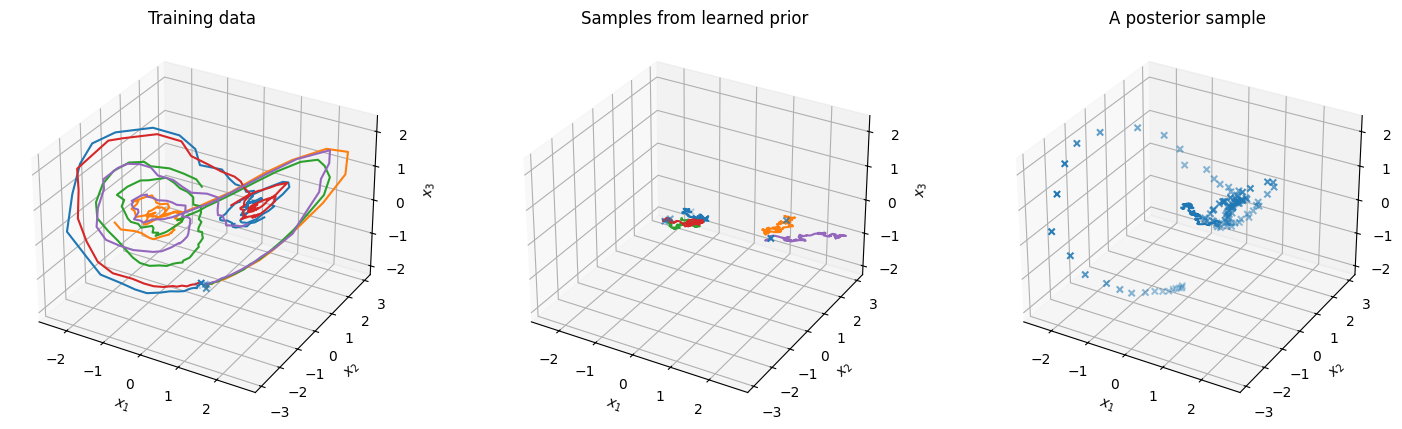

In [30]:
visualize(latent_sde, ts, xs, num_samples=5, key=vis_key)

In [31]:
optim = optax.adam(learning_rate=lr)
opt_state = optim.init(eqx.filter(latent_sde, eqx.is_array))

iterations = jnp.array(0.0)

@eqx.filter_value_and_grad
def loss_step(model, key, its, xs):
    xs_pred, logpq = model(xs, ts, key)
    ll = normal_logprob(y=xs_pred, loc=xs, scale=scale)
    ll = jnp.mean(jnp.sum(ll, axis=(-1)), axis=-1)
    kl = jnp.mean(logpq)
    loss = -ll + kl * jnp.minimum(1.0, (its + 1) / kl_anneal_iters)
    return loss

def step(model, key, its, xs):
    loss, grads = loss_step(model, key, its, xs)
    return loss, grads

_inner_step = eqx.filter_vmap(step, in_axes=(None, 0, None, 0))
step_fn = eqx.filter_pmap(_inner_step, in_axes=(None, 0, None, None))

@eqx.filter_jit
def update(model, loss, grads, opt_state):
    grads = jax.tree_util.tree_map(lambda x: x.mean(axis=(0, 1)) if x is not None else x, grads)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, loss.mean(), opt_state

10
Iteration 0.0 	 Loss: 25328.928
Iteration 100.0 	 Loss: 5750.781
Iteration 200.0 	 Loss: 1116.215
Plotting samples


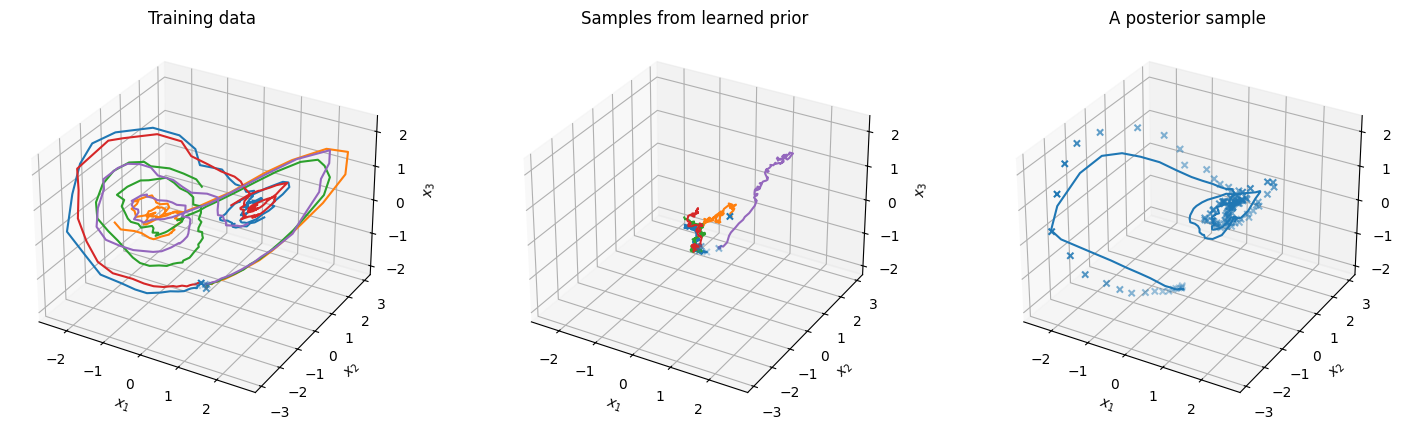

Iteration 300.0 	 Loss: 465.622
Iteration 400.0 	 Loss: 167.121
Plotting samples


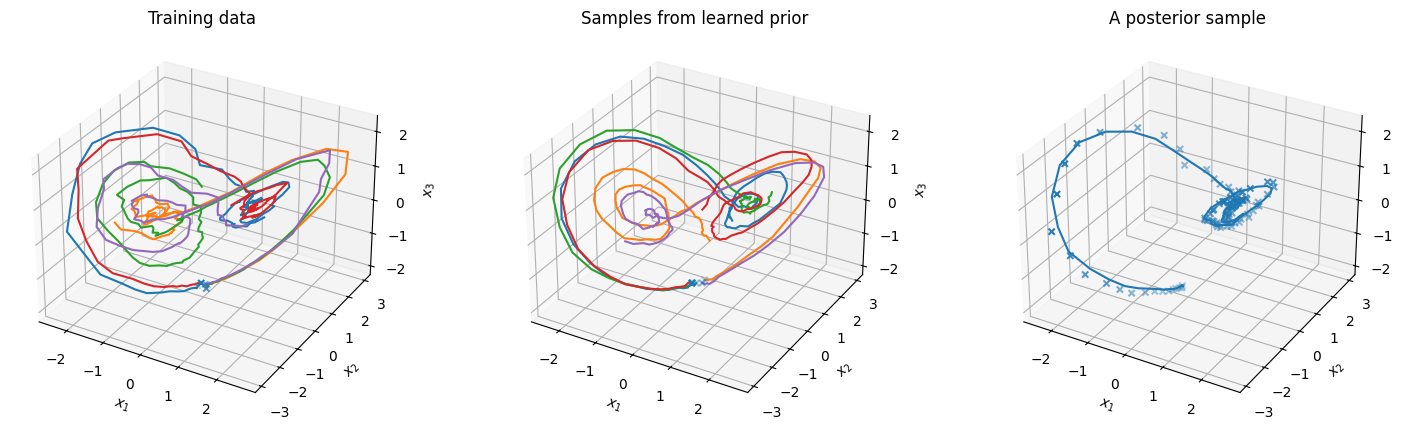

Iteration 500.0 	 Loss: 122.469


In [ ]:
losses = []
num_devices = len(jax.devices())
print(num_devices)

while iterations < train_iters:
    # optimizing
    key, training_key = jrandom.split(key)
    training_keys = jax.random.split(training_key, (num_devices, batch_size))
    indices = jax.random.choice(key, len(xs), shape=(batch_size,), replace=False)
    loss, grads = step_fn(latent_sde, training_keys, iterations, xs[indices])
    latent_sde, loss, opt_state = update(latent_sde, loss, grads, opt_state)
    if iterations % pause_freq == 0:
        print(f"Iteration {iterations} \t Loss: {loss:.3f}")
    if iterations % plot_freq == 0 and iterations > 1:
        print("Plotting samples")
        visualize(latent_sde, ts, xs, key=vis_key)
        plt.show()
    losses.append(loss)
    iterations += 1

In [ ]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()